In [1]:
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.signal import savgol_filter
from utils.plot_utils import set_fontsize
from utils.binning_utils import bin_dataset_switching
from utils.hdf_utils import load_measurement_data_devices_attrs
from utils.plot_utils import plot_binned_dataset_switching
from utils.binning_utils import bin_data, find_nearest_idx, combine_arrays_irregular, \
                                average_binned_data, bin_dataset_switching

In [12]:
fname = "2020_11_18.hdf"
dset_name = "1605839266 power scan J2J3 with ratio"
attr_name = 'PXIe5171 DummyFunc'

devices = ()

In [4]:
pmt_channel = 1
shutter_channel = 2

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

In [556]:
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pmt_data -= pmt_data[:,-200:].mean(axis = 1)[:, np.newaxis]
shutter_data = np.array([pxie[idx][:,shutter_channel].mean() for idx in range(1,len(pxie)+1)])
current_data = np.array([float(pxie_attrs[idx][attr_name]) for idx in range(1,len(pxie)+1)])

In [557]:
# each amp current measurement has 2000 shots, with 50 shots per spot
ncurrents = np.unique(current_data).size # number of different amp currents
nbunched = 50 # number of shots on the same spot

In [558]:
pmt_data_reshaped = pmt_data.reshape(ncurrents,2000,2500)
currents = current_data.reshape(-1,2000).mean(axis = 1).round(2)
shutter_data_reshaped = shutter_data.reshape(ncurrents,2000)

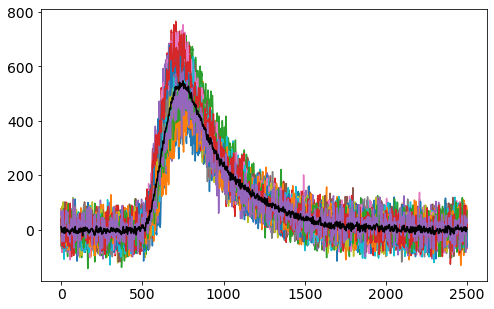

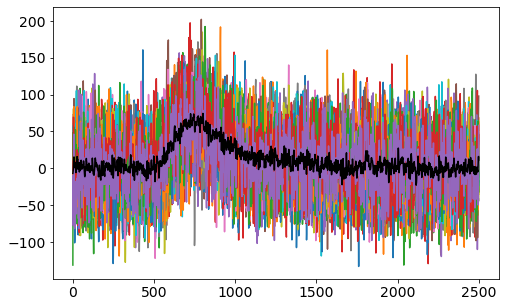

In [582]:
# taking a look at a bunch of shots
idx = 39

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pmt_data_reshaped[0].reshape(-1,nbunched,2500)[idx][::2].T)
ax.plot(pmt_data_reshaped[0].reshape(-1,nbunched,2500)[idx][::2].mean(axis = 0), color = 'k')
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pmt_data_reshaped[0].reshape(-1,nbunched,2500)[idx][1::2].T)
ax.plot(pmt_data_reshaped[0].reshape(-1,nbunched,2500)[idx][1::2].mean(axis = 0), color = 'k')
set_fontsize(ax, 14)

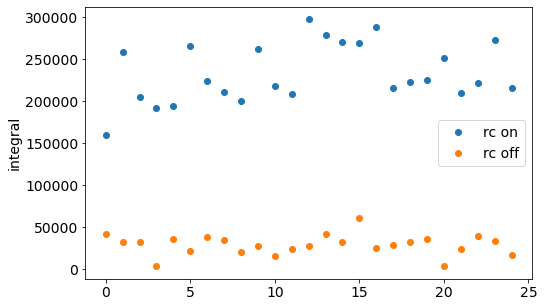

In [590]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.trapz(pmt_data_reshaped[0].reshape(-1,nbunched,2500)[idx][::2], axis = 1), '.', ms = 12, label = 'rc on')
ax.plot(np.trapz(pmt_data_reshaped[0].reshape(-1,nbunched,2500)[idx][1::2], axis = 1), '.', ms = 12, label = 'rc off')
ax.legend(fontsize = 14)
ax.set_ylabel('integral')
set_fontsize(ax, 14)

In [602]:
print(np.std(np.trapz(pmt_data_reshaped[0].reshape(-1,nbunched,2500)[idx][::2], axis = 1)))
print(np.std(np.trapz(pmt_data_reshaped[0].reshape(-1,nbunched,2500)[idx][::2], axis = 1))/np.sqrt(25))

34585.081772829326
6917.016354565865


In [603]:
print(np.std(np.trapz(pmt_data_reshaped[0].reshape(-1,nbunched,2500)[idx][1::2], axis = 1)))
print(np.std(np.trapz(pmt_data_reshaped[0].reshape(-1,nbunched,2500)[idx][1::2], axis = 1))/np.sqrt(25))

11971.165270511005
2394.233054102201


(array([2., 0., 2., 5., 3., 9., 3., 0., 0., 1.]),
 array([ 2918.98 ,  8701.684, 14484.388, 20267.092, 26049.796, 31832.5  ,
        37615.204, 43397.908, 49180.612, 54963.316, 60746.02 ]),
 <BarContainer object of 10 artists>)

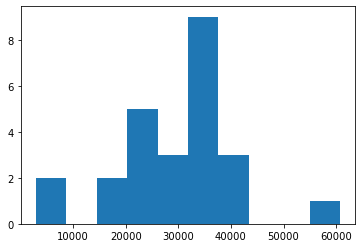

In [596]:
plt.hist(np.trapz(pmt_data_reshaped[0].reshape(-1,nbunched,2500)[idx][1::2], axis = 1))

In [560]:
def get_shutter_slice(val):
    state = val > 2e4
    if state:
        return np.s_[::2], np.s_[1::2]
    else:
        return np.s_[1::2], np.s_[::2]

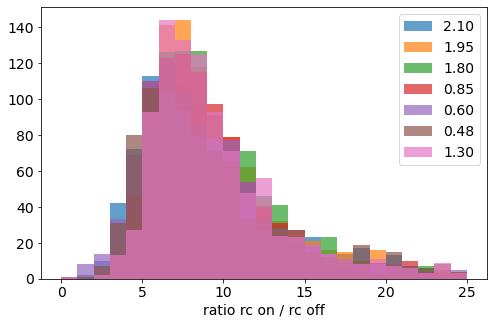

In [647]:
fig, ax = plt.subplots(figsize = (8,5))

for idc in range(len(pmt_data_reshaped)):
    io = []
    ic = []
    for idx in range(40):
        slice_open, slice_closed = get_shutter_slice(shutter_data_reshaped[idc].reshape(-1,nbunched)[idx][0])
        io.extend(np.trapz(pmt_data_reshaped[idc].reshape(-1,nbunched,2500)[idx][slice_open], axis = 1))
        ic.extend(np.trapz(pmt_data_reshaped[idc].reshape(-1,nbunched,2500)[idx][slice_closed], axis = 1))

    io = np.asarray(io)
    ic = np.asarray(ic)
    
    r = io/ic
    r[r < 0] = np.nan
    
    ax.hist(r, bins = np.linspace(0,25,26), alpha = 0.7, label = f'{currents[idc]:.2f}')
    
ax.set_xlabel('ratio rc on / rc off')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)

median = 8.158
median = 8.589
median = 8.926
median = 8.687
median = 8.418
median = 8.280
median = 8.531


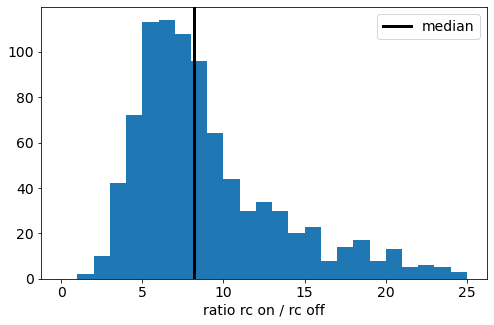

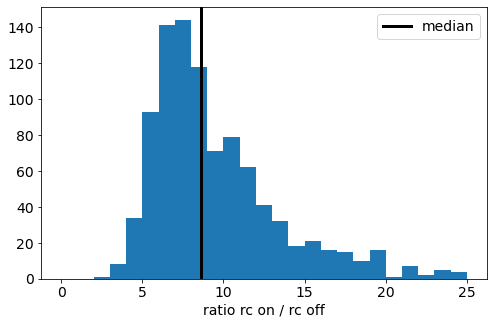

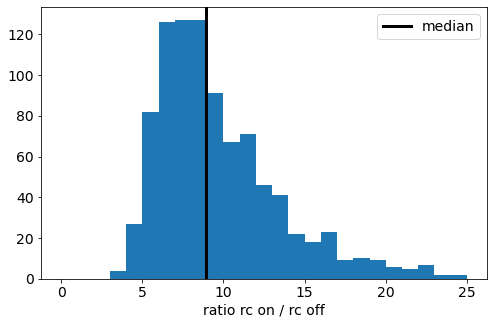

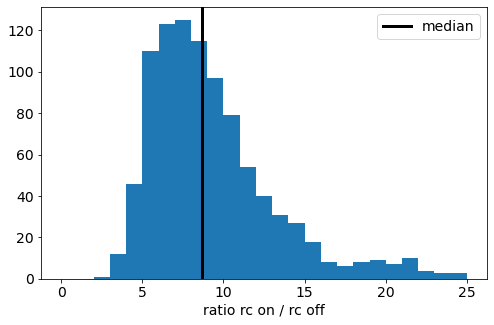

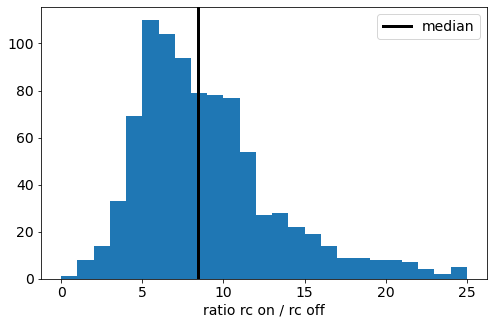

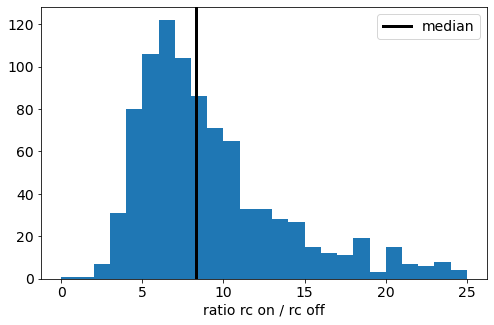

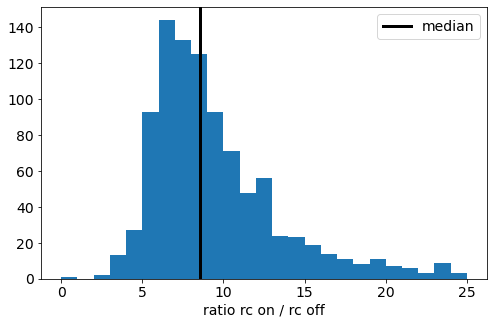

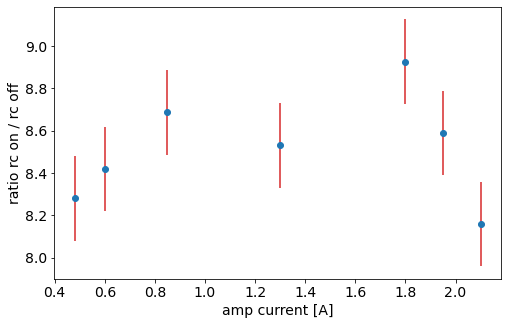

In [648]:
ratios = {c:None for c in currents}
for idc in range(len(pmt_data_reshaped)):
    io = []
    ic = []
    for idx in range(40):
        slice_open, slice_closed = get_shutter_slice(shutter_data_reshaped[idc].reshape(-1,nbunched)[idx][0])
        io.extend(np.trapz(pmt_data_reshaped[idc].reshape(-1,nbunched,2500)[idx][slice_open], axis = 1))
        ic.extend(np.trapz(pmt_data_reshaped[idc].reshape(-1,nbunched,2500)[idx][slice_closed], axis = 1))

    io = np.asarray(io)
    ic = np.asarray(ic)
    
    r = io/ic
    r[r < 0] = np.nan
    
    fig, ax = plt.subplots(figsize = (8,5))
    ax.hist(r, bins = np.linspace(0,25,26))
    ax.set_xlabel('ratio rc on / rc off')

    ax.axvline(np.nanmedian(r), label = 'median', color = 'k', lw = 3)

    ax.legend(fontsize = 14)
    set_fontsize(ax, 14)
    
    ratios[currents[idc]] = np.nanmedian(r)

    print(f'median = {np.nanmedian(r):.3f}')
    
c = list(ratios.keys())
r = list(ratios.values())
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(c, r, yerr = 0.2, fmt = '.', ms = 12, ecolor = 'C3')
ax.set_xlabel('amp current [A]')
ax.set_ylabel('ratio rc on / rc off')
set_fontsize(ax, 14)

In [717]:
shutter_data_reshaped.shape

(7, 2000)

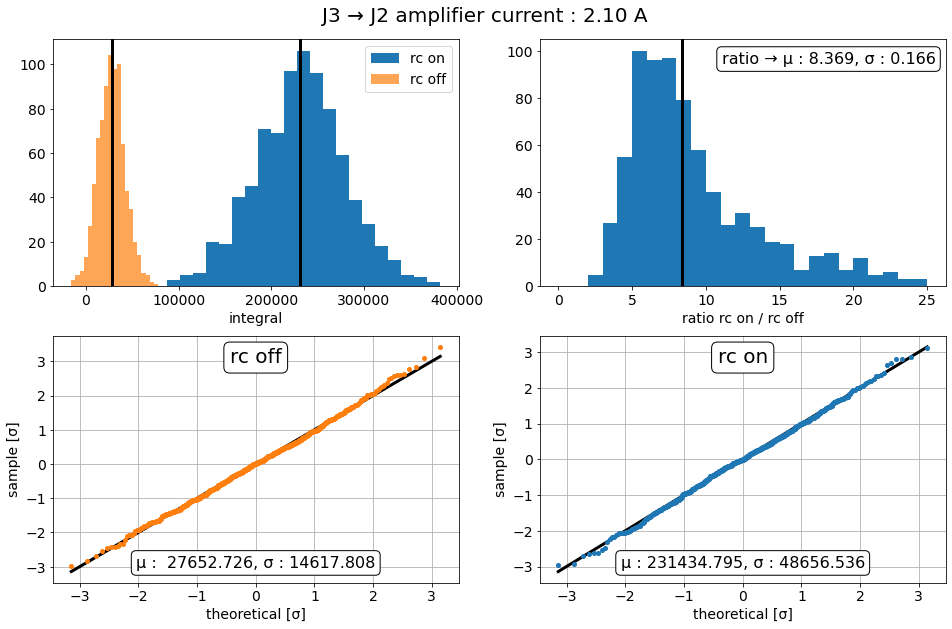

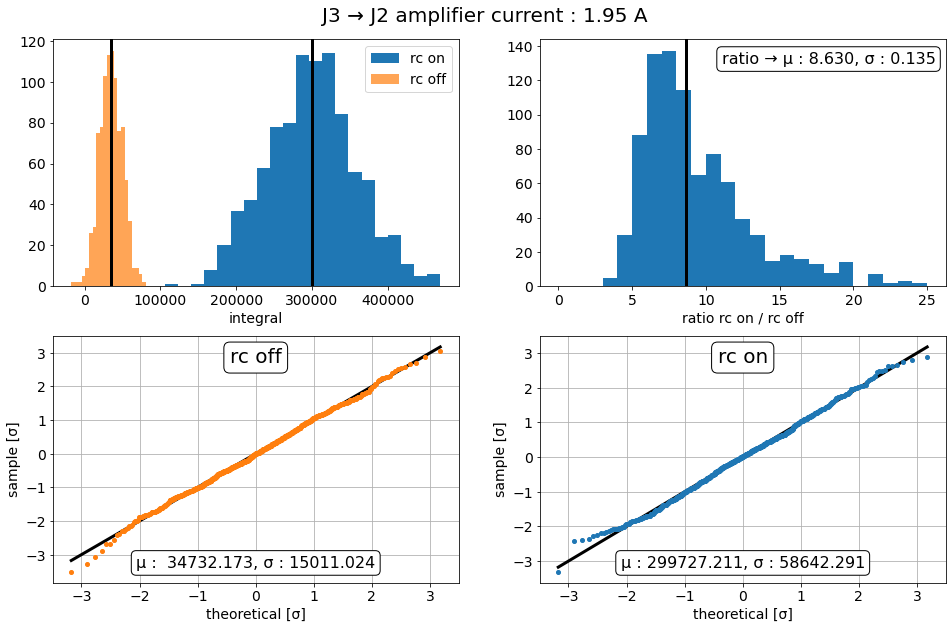

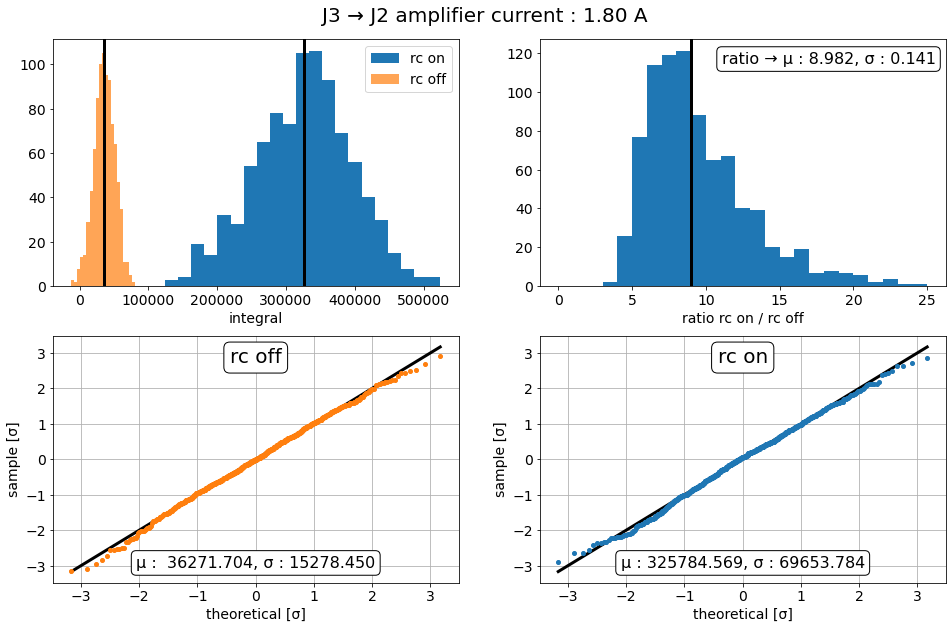

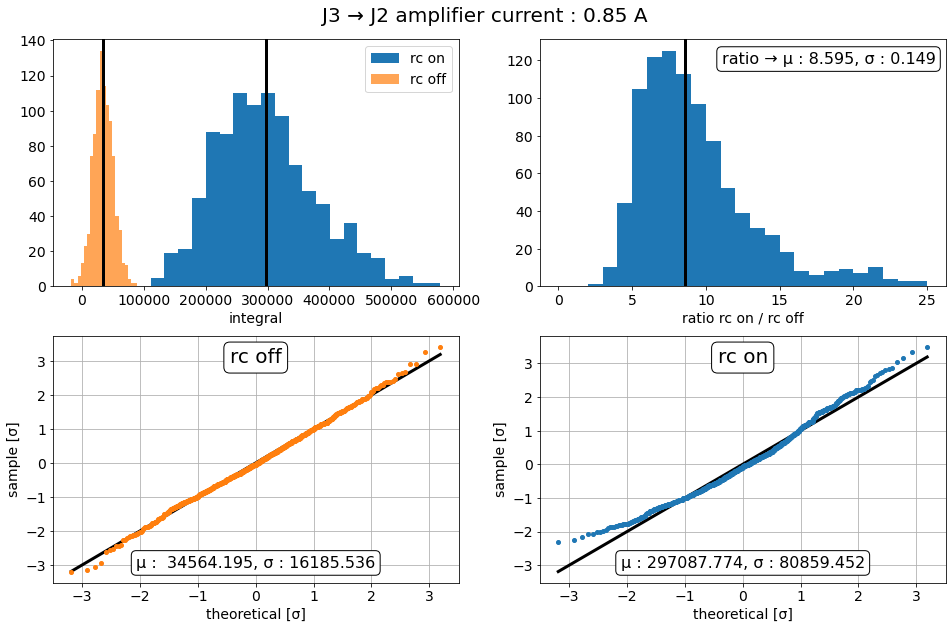

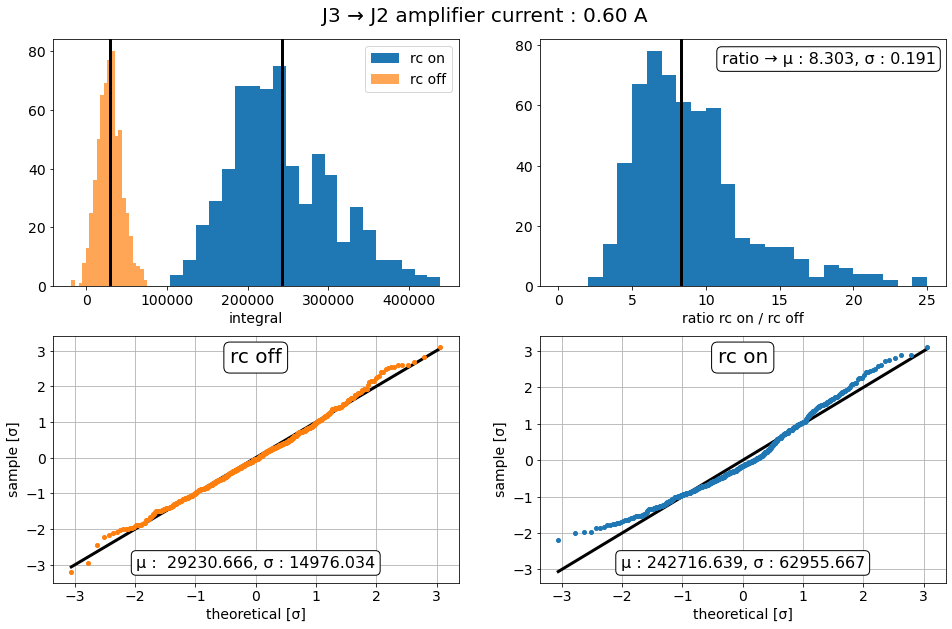

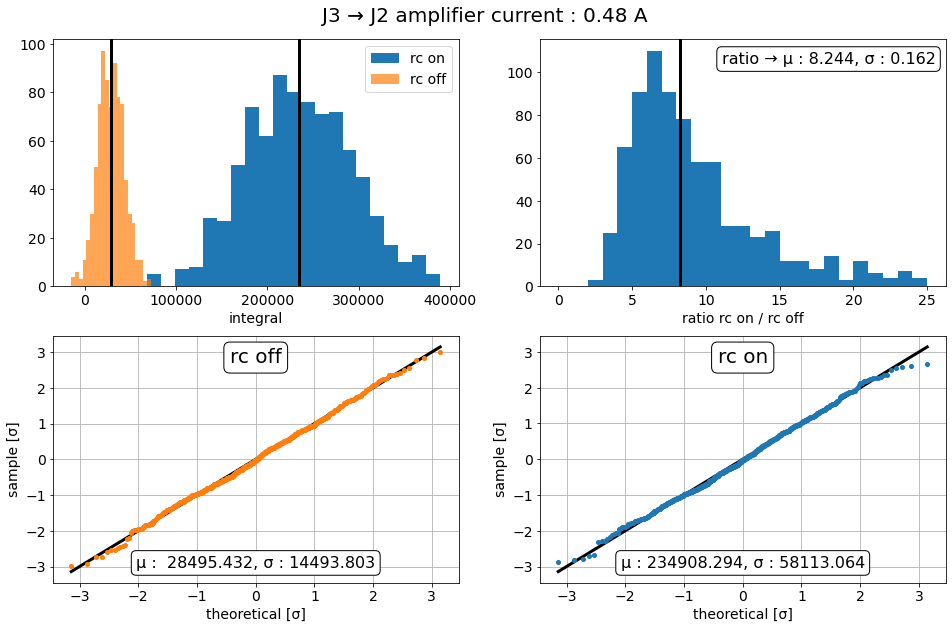

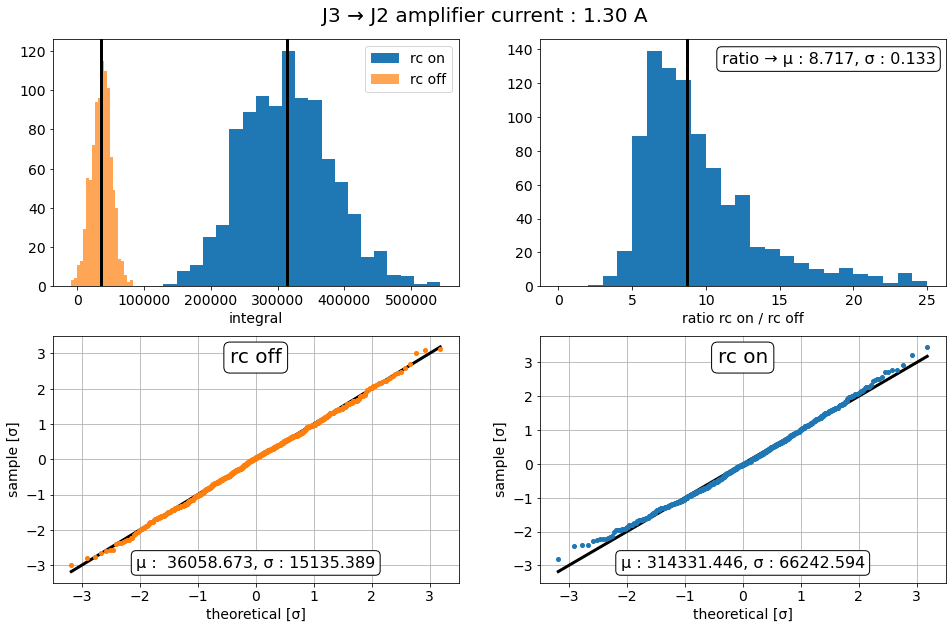

In [913]:
from scipy.stats import probplot

intc_limit = 20e3
into_lowlim = 50e3
into_highlim = 1000e3
rlimit = 0.995

props = dict(boxstyle='round', facecolor='white', alpha=1)
ratios = {c:[] for c in currents}

for idc in range(len(pmt_data_reshaped)):
    io = []
    ic = []
    
    suspect = False
    
    pmt_bunched = pmt_data_reshaped[idc].reshape(-1,nbunched,2500)
    shutter_bunched = shutter_data_reshaped[idc].reshape(-1,nbunched)
    
    for idx in range(len(pmt_bunched)):
        slice_open, slice_closed = get_shutter_slice(shutter_bunched[idx][0])
        trapio = np.trapz(pmt_bunched[idx][slice_open], axis = 1)
        trapic = np.trapz(pmt_bunched[idx][slice_closed], axis = 1)
        if (np.mean(trapic) > int_limit) and (np.mean(trapio) < into_highlim):
            trapio[trapio < into_lowlim] = np.nan
            io.extend(trapio)
            ic.extend(trapic)
        else:
            pass

    io = np.asarray(io)
    ic = np.asarray(ic)

    
    fig, axes = plt.subplots(2,2,figsize = (16,10))
    fig.suptitle(f'J3 → J2 amplifier current : {currents[idc]:.2f} A', fontsize = 20,
                 y = .925, va = 'top')
    
    ax = axes[0,1]
    ax.hist(io/ic, bins = np.linspace(0,25,26))
    ax.set_xlabel('ratio rc on / rc off')
    
    
    io = np.asarray([val for val in io if not np.isnan(val)])
    ic = np.asarray([val for val in ic if not np.isnan(val)])
    
    ax = axes[0,0]
    
    no, bo, _ = ax.hist(io, bins = 21, label = 'rc on')
    nc, bc, _ = ax.hist(ic, bins = 21, label = 'rc off', alpha = 0.7)
    
    ax.axvline(np.nanmean(io), lw = 3, color = 'k')
    ax.axvline(np.nanmean(ic), lw = 3, color = 'k')
    
    ax.locator_params(nbins=8)
    ax.set_xlabel('integral')

    ax.legend(fontsize = 14)
    
    ffunc = lambda x, a, b: a*x+b
    
    (osm, osr), (fitparams) = probplot(ic, dist = 'norm', fit = True)   
    
    suspect |= fitparams[-1] < rlimit
    
    μc = fitparams[1]
    σc = fitparams[0]

    _x = np.linspace(osm.min(), osm.max(), 101)
    
    ax = axes[1,0]
    ax.plot(_x, (ffunc(_x, *fitparams[:2]) - μc)/σc, lw = 3, color = 'k')
    ax.plot(osm, (osr - μc)/σc, '.', ms = 8, color = 'C1')
    
    ax.set_xlabel('theoretical [σ]')
    ax.set_ylabel('sample [σ]')
    ax.text(0.5, 0.95, 'rc off', fontsize = 20, transform = ax.transAxes, ha = 'center', va = 'top', bbox = props)
    ax.text(0.5, 0.05, f'μ : {μc:>10.3f}, σ : {σc:.3f}',
            transform = ax.transAxes, ha = 'center', va = 'bottom', fontsize = 16, bbox = props)
    ax.grid(True)    

    (osm, osr), (fitparams) = probplot(io, dist = 'norm', fit = True) 
    
    suspect |= fitparams[-1] < rlimit
    
    μo = fitparams[1]
    σo = fitparams[0]
    
    _x = np.linspace(osm.min(), osm.max(), 101)
    
    ax = axes[1,1]
    ax.plot(_x, (ffunc(_x, *fitparams[:2]) - μo)/σo, lw = 3, color = 'k')
    ax.plot(osm, (osr - μo)/σo, '.', ms = 8, color = 'C0')
    
    ax.set_xlabel('theoretical [σ]')
    ax.set_ylabel('sample [σ]')
    ax.text(0.5, 0.95, 'rc on', fontsize = 20, transform = ax.transAxes, ha = 'center', va = 'top', bbox = props)
    ax.text(0.5, 0.05, f'μ : {μo:>10.3f}, σ : {σo:.3f}',
            transform = ax.transAxes, ha = 'center', va = 'bottom', fontsize = 16, bbox = props)
    ax.grid(True)
    
    for ax in axes.flatten():
        set_fontsize(ax, 14)

    μr = μo/μc
    σr = np.abs(μr) * np.sqrt((σo/μo/np.sqrt(len(io)))**2 + (σc/μc/np.sqrt(len(ic)))**2)
    ratios[currents[idc]] = (μr, σr, suspect)
    
    ax = axes[0,1]
    ax.axvline(μr, color = 'k', lw = 3)
    ax.text(0.975, 0.95, f'ratio → μ : {μr:.3f}, σ : {σr:.3f}',
                transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 16, bbox = props)  

In [914]:
current_to_power = {0.48: 17, 0.6: 20, 0.85: 24, 1.8: 26, 1.95: 28.75, 2.1: 30, 1.3: 25}

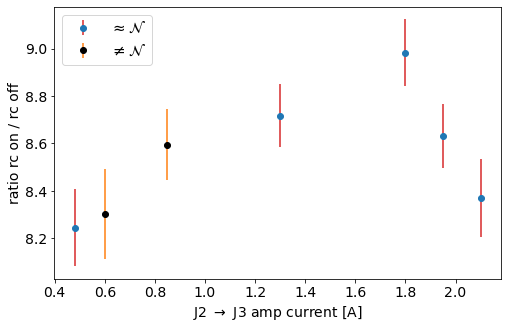

In [915]:
c = list(ratios.keys())
r, e, s = zip(*list(ratios.values()))
c,r,e,s = np.asarray(c), np.asarray(r), np.asarray(e), np.asarray(s)

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(c[~s], r[~s], yerr = e[~s], fmt = '.', ms = 12, ecolor = 'C3', label = r'$\approx\mathcal{N}$')
ax.errorbar(c[s], r[s], yerr = e[s], fmt = '.', ms = 12, ecolor = 'C1', color = 'k', label = r'$\neq\mathcal{N}$')

ax.legend(fontsize = 15)
ax.set_xlabel(r'J2 $\rightarrow$ J3 amp current [A]')
ax.set_ylabel('ratio rc on / rc off')
set_fontsize(ax, 14)

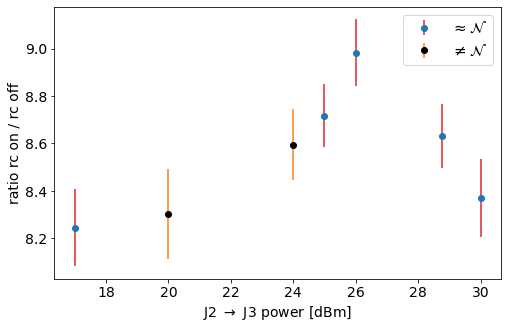

In [916]:
c = list(ratios.keys())
r, e, s = zip(*list(ratios.values()))
c,r,e,s = np.asarray(c), np.asarray(r), np.asarray(e), np.asarray(s)
p = np.array([current_to_power[ci] for ci in c])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(p[~s], r[~s], yerr = e[~s], fmt = '.', ms = 12, ecolor = 'C3', label = r'$\approx\mathcal{N}$')
ax.errorbar(p[s], r[s], yerr = e[s], fmt = '.', ms = 12, ecolor = 'C1', color = 'k', label = r'$\neq\mathcal{N}$')

ax.legend(fontsize = 15)
ax.set_xlabel(r'J2 $\rightarrow$ J3 power [dBm]')
ax.set_ylabel('ratio rc on / rc off')
set_fontsize(ax, 14)

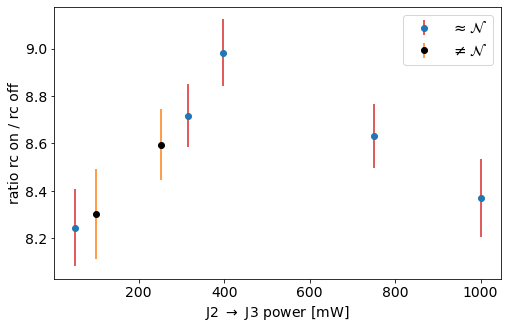

In [917]:
c = list(ratios.keys())
r, e, s = zip(*list(ratios.values()))
c,r,e,s = np.asarray(c), np.asarray(r), np.asarray(e), np.asarray(s)
p = np.array([current_to_power[ci] for ci in c])
pmW = 10**(p/10)

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(pmW[~s], r[~s], yerr = e[~s], fmt = '.', ms = 12, ecolor = 'C3', label = r'$\approx\mathcal{N}$')
ax.errorbar(pmW[s], r[s], yerr = e[s], fmt = '.', ms = 12, ecolor = 'C1', color = 'k', label = r'$\neq\mathcal{N}$')

ax.legend(fontsize = 15)
ax.set_xlabel(r'J2 $\rightarrow$ J3 power [mW]')
ax.set_ylabel('ratio rc on / rc off')
set_fontsize(ax, 14)

In [876]:
integral_limit = 10e-3
ratios = {c:[] for c in currents}
for c,d,shut_state in zip(currents, pmt_data_reshaped, shutter_data_reshaped):
    bunched = d.reshape(-1,nbunched,2500)
    shut_bunched = shut_state.reshape(-1,nbunched)
    for st, bunch in zip(shut_bunched, bunched):
        slice_open, slice_closed = get_shutter_slice(st[0])
        mo = bunch[slice_open].mean(axis = 0)
        mc = bunch[slice_closed].mean(axis = 0)
        io = np.trapz(mo)
        ic = np.trapz(mc)
        if (io < integral_limit) or (ic < integral_limit):
            ratios[c].append(np.nan)
        else:
            ratios[c].append(io/ic)

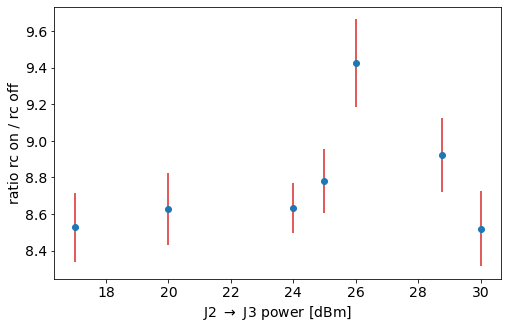

In [881]:
c = list(ratios.keys())
r = [np.nanmean(val) for val in ratios.values()]
e = [np.nanstd(val)/np.sqrt(np.sum(~np.isnan(val))) for val in ratios.values()]
p = np.array([current_to_power[ci] for ci in c])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(p, r, yerr = e, fmt = '.', ms = 12, ecolor = 'C3')
ax.set_xlabel(r'J2 $\rightarrow$ J3 power [dBm]')
ax.set_ylabel('ratio rc on / rc off')
set_fontsize(ax, 14)

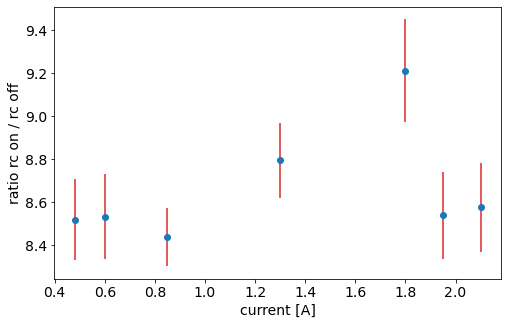

In [577]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(currents, [np.nanmedian(val) for val in ratios.values()], e, 
            fmt = '.', ms = 12, ecolor = 'C3')
ax.set_xlabel('current [A]')
ax.set_ylabel('ratio rc on / rc off')
set_fontsize(ax, 14)

In [882]:
from scipy.optimize import curve_fit

def gaussian(x, μ, σ):
    return 1/np.sqrt(2*np.pi*σ**2) * np.exp(-(x-μ)**2/(2*σ**2))

def normal(x, μ, σ):
    return np.exp(-(x-μ)**2/(2*σ**2))

fit_func = lambda x,μ,σ,a: a*normal(x,μ,σ)

mean : 8.520; fit : 8.344; median : 8.576
mean : 8.922; fit : 7.382; median : 8.538
mean : 9.424; fit : 8.750; median : 9.209
mean : 8.634; fit : 8.585; median : 8.438
mean : 8.628; fit : 8.500; median : 8.533
mean : 8.528; fit : 8.544; median : 8.519
mean : 8.780; fit : 8.264; median : 8.794


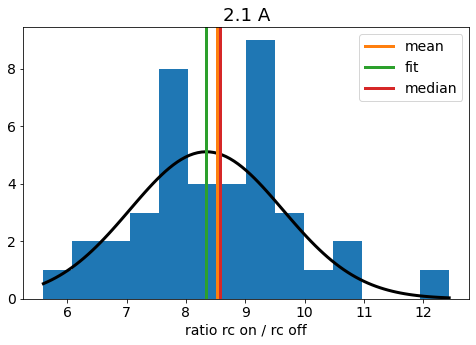

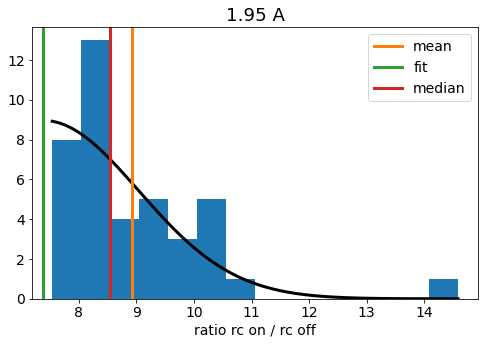

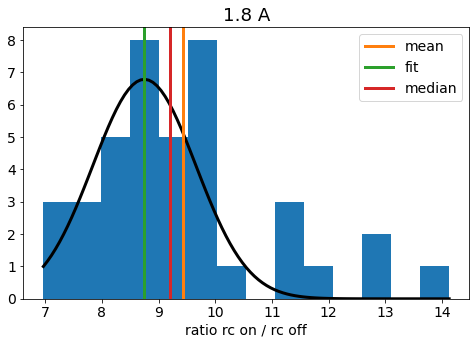

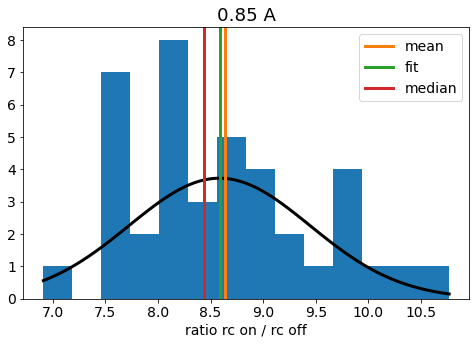

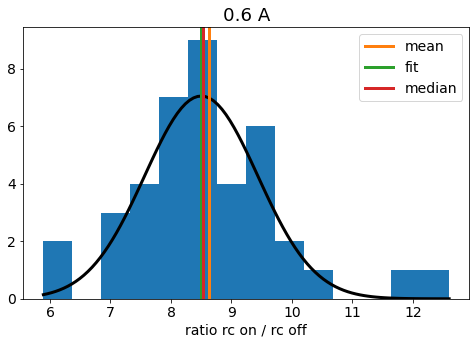

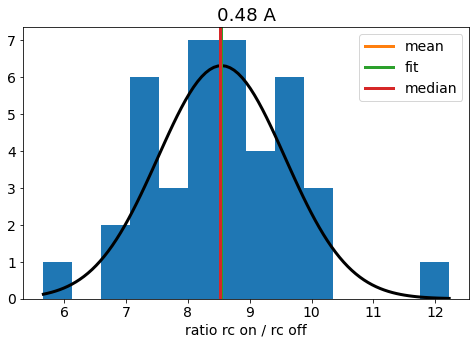

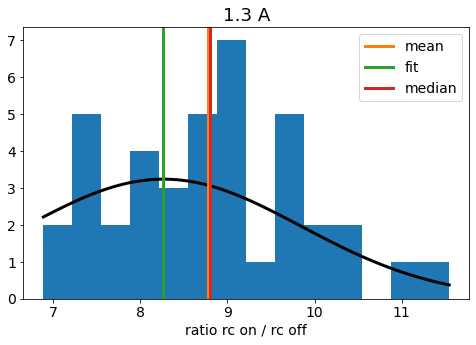

In [883]:
ratios = {c: None for c in currents}
for key, val in ratios.items():
    fig, ax = plt.subplots(figsize = (8,5))
    y, bins, _ = ax.hist(val, bins = np.linspace(max(5,np.nanmin(val)),min(np.nanmax(val), np.nanmean(val)*2),15))

    _x = np.linspace(bins.min(), bins.max(), 101)
    x = bins[:-1]+np.diff(bins)[0]/2
    p0 = (np.mean(r), np.std(r), np.max(y))
    sigma = np.sqrt(y)
    sigma[sigma == 0] = 1
    popt, pcov = curve_fit(fit_func,x,y, p0 = p0, sigma = sigma)
    ax.plot(_x, fit_func(_x, *popt), color = 'k', lw = 3)

    ax.set_title(f'{key} A')
    ax.set_xlabel('ratio rc on / rc off')
    
    ax.axvline(np.nanmean(val), lw = 3, color = 'C1', label = 'mean')
    ax.axvline(popt[0], lw = 3, color = 'C2', label = 'fit')
    ax.axvline(np.nanmedian(val), lw = 3, color = 'C3', label = 'median')
    
    ax.legend(fontsize = 14)
    set_fontsize(ax, 14)
    
    
    
    print(f'mean : {np.nanmean(val):.3f}; fit : {popt[0]:.3f}; median : {np.nanmedian(val):.3f}')

In [884]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    values = np.asarray(values)
    weights = np.asarray(weights)
    filter_nan = ~np.isnan(values)
    average = np.average(values[filter_nan], weights=weights[filter_nan])
    # Fast and numerically precise:
    variance = np.average((values[filter_nan]-average)**2, weights=weights[filter_nan])
    return (average, np.sqrt(variance))

In [885]:
integral_limit = 10e3
ratios = {c:[] for c in currents}
for c,d,shut_state in zip(currents, pmt_data_reshaped, shutter_data_reshaped):
    bunched = d.reshape(-1,nbunched,2500)
    shut_bunched = shut_state.reshape(-1,nbunched)
    for st, bunch in zip(shut_bunched, bunched):
        slice_open, slice_closed = get_shutter_slice(st[0])
        
        io = np.trapz(bunch[slice_open], axis = 1)
        ic = np.trapz(bunch[slice_closed], axis = 1)
        stdo = np.std(io)/np.sqrt(nbunched)
        stdc = np.std(ic)/np.sqrt(nbunched)
        
        r = io.mean()/ic.mean()
        e = r * np.sqrt((stdo/io.mean())**2 + (stdc/ic.mean())**2)
        
        if (io.mean() < integral_limit) or (ic.mean() < integral_limit):
            ratios[c].append((np.nan, np.nan))
        else:
            ratios[c].append((r.mean(), e))

In [886]:
ratio_weighted,error_weighted = [],[]
for val in ratios.values():
    r,e = zip(*val)
    e = np.array(e)
    rw,ew = weighted_avg_and_std(r,1/e**2)
    ew /= np.sqrt(50)
    ratio_weighted.append(rw)
    error_weighted.append(ew)

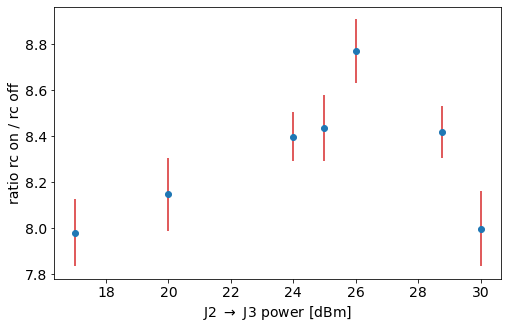

In [888]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(p, ratio_weighted, yerr = error_weighted, fmt ='.', ecolor = 'C3', ms = 12)

ax.set_xlabel(r'J2 $\rightarrow$ J3 power [dBm]')

ax.set_ylabel('ratio rc on / rc off')

set_fontsize(ax, 14)

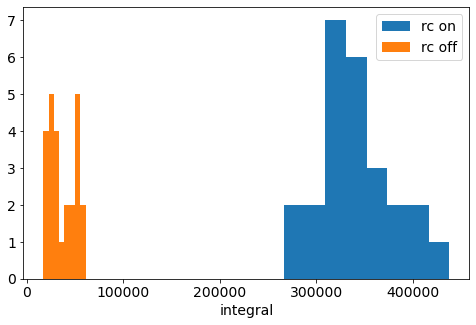

In [549]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(io, bins = 8, label = 'rc on')
ax.hist(ic, bins = 8, label = 'rc off')

ax.legend(fontsize = 14)

ax.set_xlabel('integral')
set_fontsize(ax, 14)

341102.31759999995 39490.05065078525
37323.2376 13452.877977897624


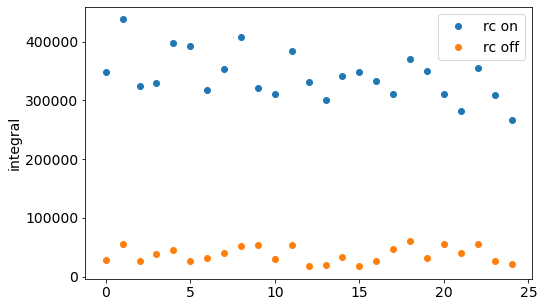

In [550]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(io, '.', label = 'rc on', ms = 12)
ax.plot(ic, '.', label = 'rc off', ms = 12)
ax.legend(fontsize = 14)
ax.set_ylabel('integral')
set_fontsize(ax, 14)
print(np.mean(io), np.std(io))
print(np.mean(ic), np.std(ic))

8.15 +/- 0.18


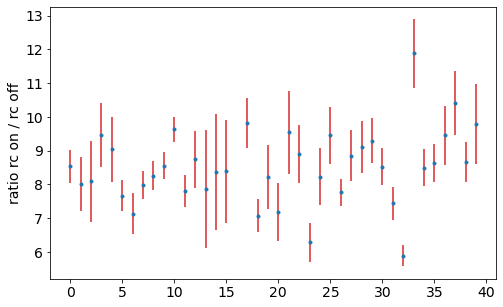

In [551]:
r,e = zip(*ratios[0.6])
r = np.array(r)
e = np.array(e)

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(x = np.arange(len(r)), y = r, yerr = e, fmt = '.', ecolor = 'C3')
ax.set_ylabel('ratio rc on / rc off')

set_fontsize(ax, 14)

rw, ew = weighted_avg_and_std(r, 1/e**2)
print(f'{rw:.2f} +/- {ew/np.sqrt(sum(~np.isnan(r))):.2f}')

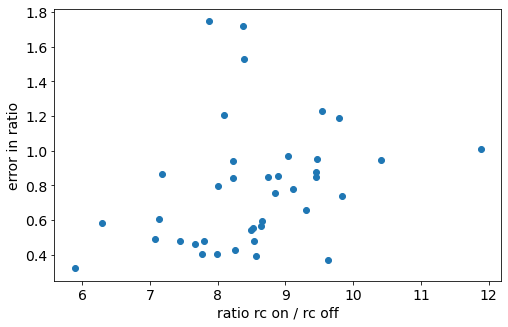

In [552]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(r, e, '.', ms = 12)

ax.set_xlabel('ratio rc on / rc off')
ax.set_ylabel('error in ratio')
set_fontsize(ax, 14)

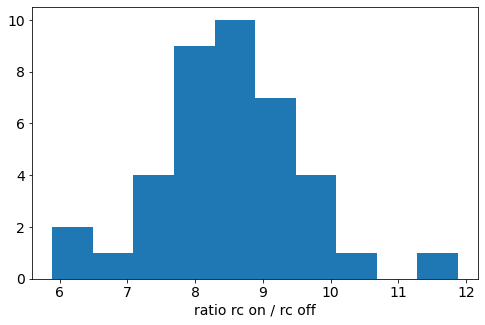

In [553]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(r)

ax.set_xlabel('ratio rc on / rc off')

set_fontsize(ax, 14)

## YAG signal

In [416]:
yag_channel = 0
yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])

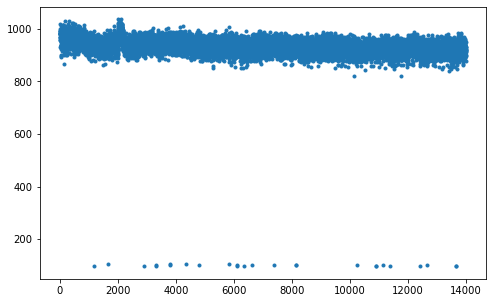

In [432]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(yag_data.max(axis = 1), '.')

In [433]:
(np.sum(yag_data.max(axis = 1) < 600))/len(yag_data) * 100

0.18571428571428572

In [434]:
np.where(yag_data.max(axis = 1) < 600)[0]+1

array([ 1171,  1651,  2897,  3311,  3319,  3793,  3798,  4346,  4807,
        5831,  6092,  6095,  6347,  6622,  7381,  8143,  8144, 10254,
       10887, 10889, 11127, 11374, 12423, 12671, 13649, 13650],
      dtype=int64)

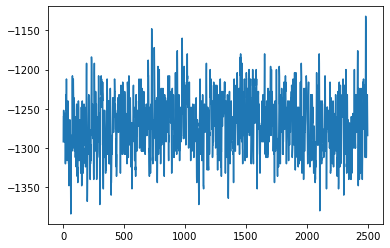

In [435]:
plt.plot(pxie[12671][:,pmt_channel])

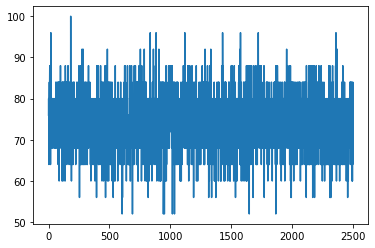

In [436]:
plt.plot(pxie[12671][:,yag_channel])

## Looking at what a normal distribution over a normal distribution gives

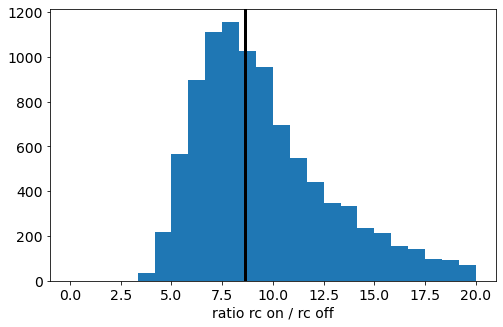

In [483]:
div = np.random.normal(340000,39490,int(10000))/np.random.normal(37323, 13453, int(10000))
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(div, bins = np.linspace(0,20,25))
ax.set_xlabel('ratio rc on / rc off')
ax.axvline(340000/39490, color = 'k', lw = 3)
set_fontsize(ax, 14)

In [484]:
mean = []
median = []
for _ in range(int(1e3)):
    div = np.random.normal(340000,39490,int(40))/np.random.normal(37323, 13453, int(40))
    mean.append(np.mean(div[div > 0]))
    median.append(np.median(div[div > 0]))

(array([ 21.,  70., 192., 250., 220., 130.,  72.,  37.,   4.,   4.]),
 array([ 7.46296219,  7.89673843,  8.33051467,  8.76429091,  9.19806715,
         9.63184339, 10.06561963, 10.49939587, 10.93317211, 11.36694836,
        11.8007246 ]),
 <BarContainer object of 10 artists>)

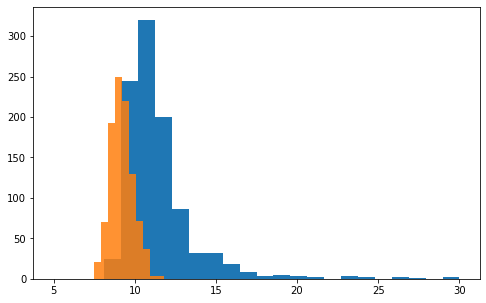

In [485]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(mean, bins = np.linspace(5,30,25))
ax.hist(median, alpha = 0.85)

In [486]:
np.mean(mean)

12.23591586843182

In [487]:
np.median(mean)

10.94892927481155

In [488]:
np.mean(median)

9.197885724821337

In [489]:
np.median(median)

9.150515695319754

### Ratio Distribution Fit

In [1000]:
from scipy.integrate import quad

def ratio_pdf(z,μx,μy,σx,σy):
    a = lambda z: np.sqrt(1/σx**2 * z**2 + 1/σy**2)
    b = lambda z: μx/σx**2 * z + μy/σy**2
    c = (μx/σx)**2 + (μy/σy)**2
    d = lambda z: np.exp((b(z)**2-c*a(z)**2)/(2*a(z)**2))
    ncdf = lambda u: (1/(np.sqrt(2*np.pi)))*np.exp(-1/2 * u**2) # normal cumulative distribution funtion
    Φ = lambda t: quad(ncdf,-np.inf,t)[0]
    if isinstance(z, (np.ndarray, list, tuple)):
        Φarrp = np.array([Φ(b(zi)/a(zi)) for zi in z])
        Φarrn = np.array([Φ(-b(zi)/a(zi)) for zi in z])
    return b(z)*d(z)/(a(z)**3) * 1/(np.sqrt(2*np.pi)*σx*σy)*(Φarrp - Φarrn) + 1/(a(z)**2+np.pi*σx*σy) * np.exp(-c/2)    

In [1003]:
μx = 325784
μy = 36271
σx = 69653
σy = 15278

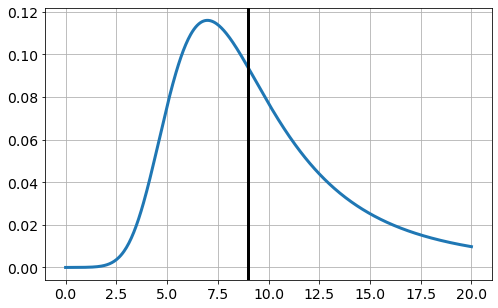

In [1007]:
_z = np.linspace(0,20,501)

fig, ax = plt.subplots(figsize = (8,5))

ax.plot(_z, ratio_pdf(_z, μx, μy, σx, σy), lw = 3)
ax.axvline(μx/μy, color = 'k', lw = 3)

ax.grid(True)
set_fontsize(ax, 14)

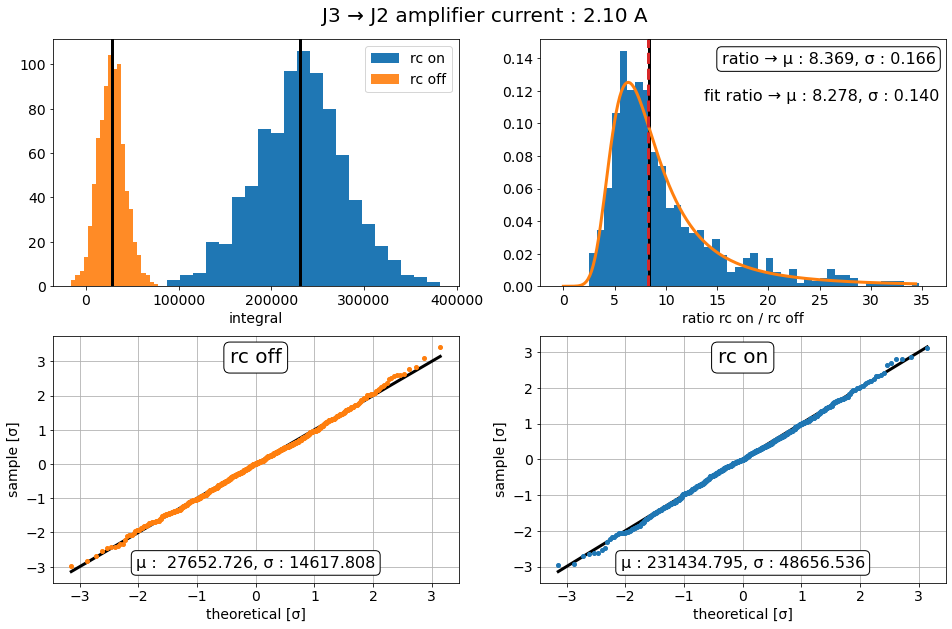

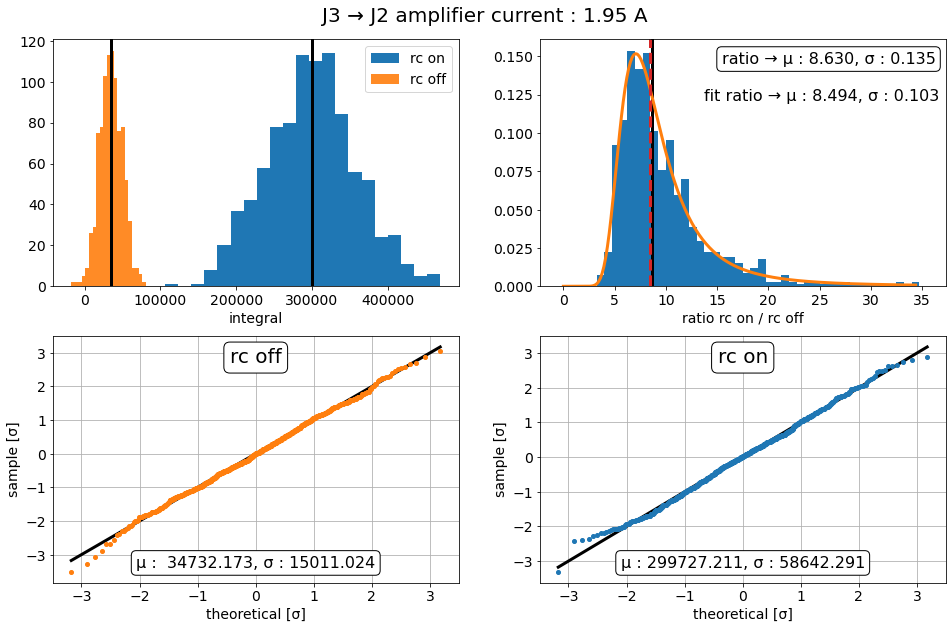

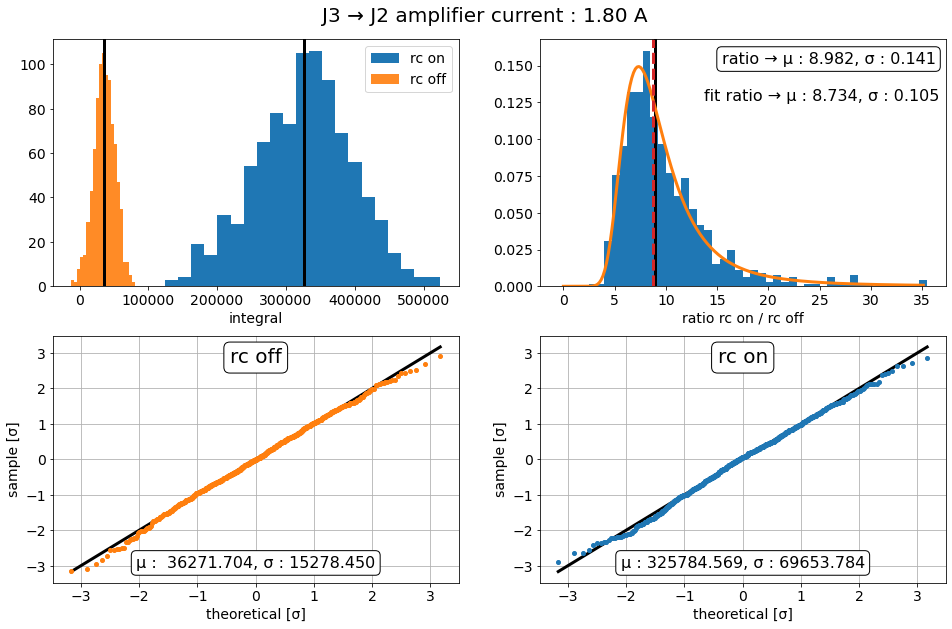

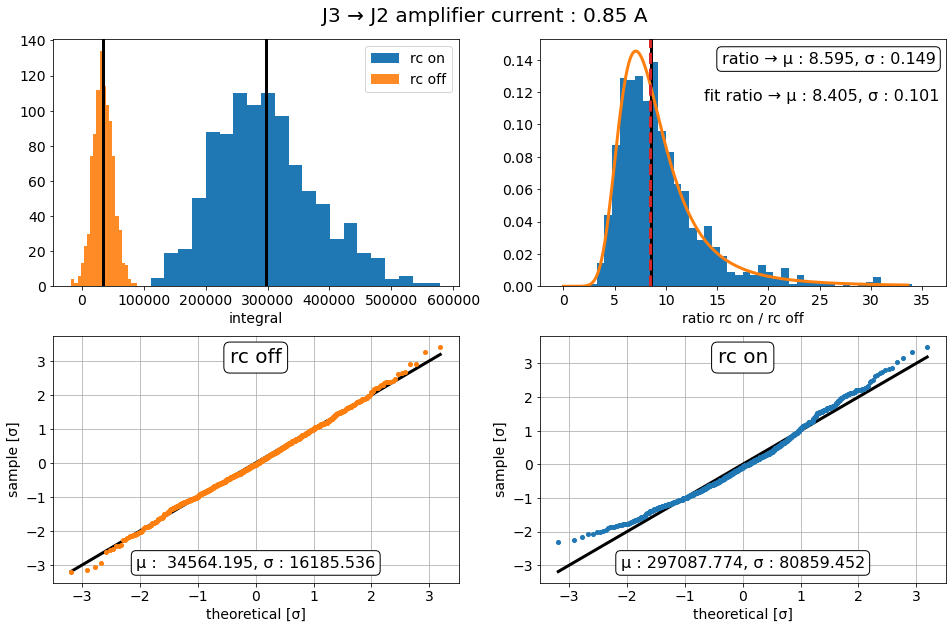

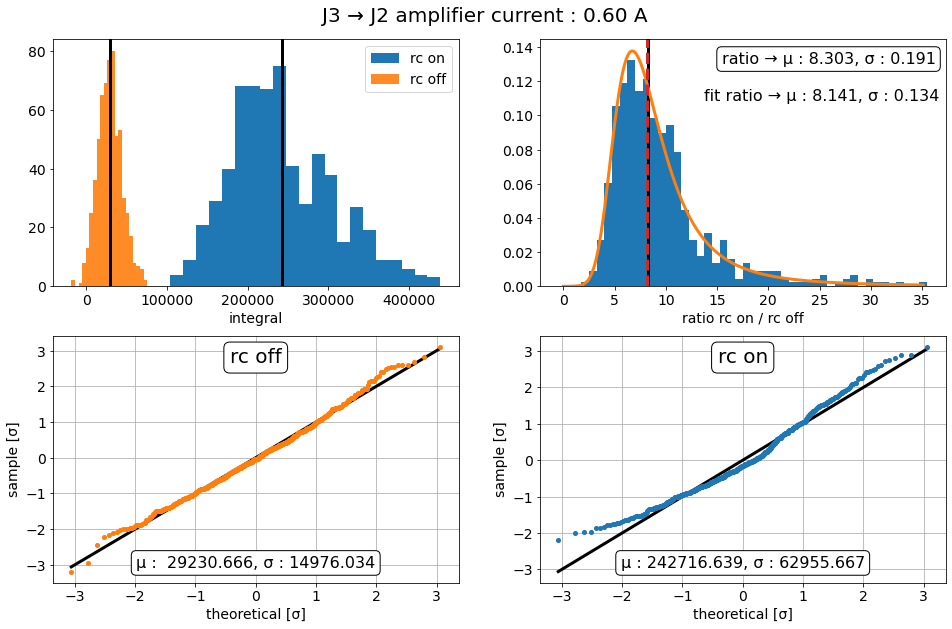

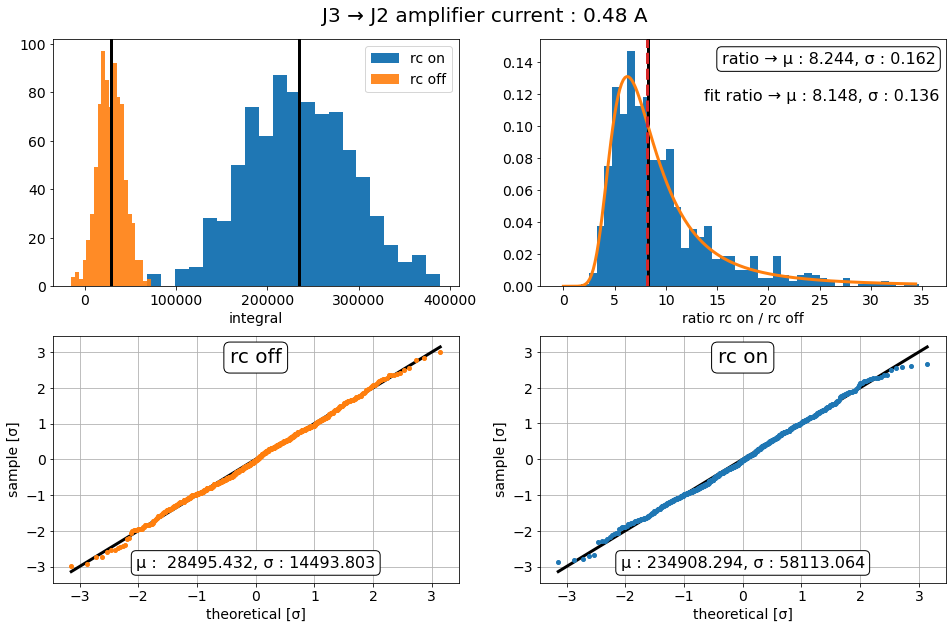

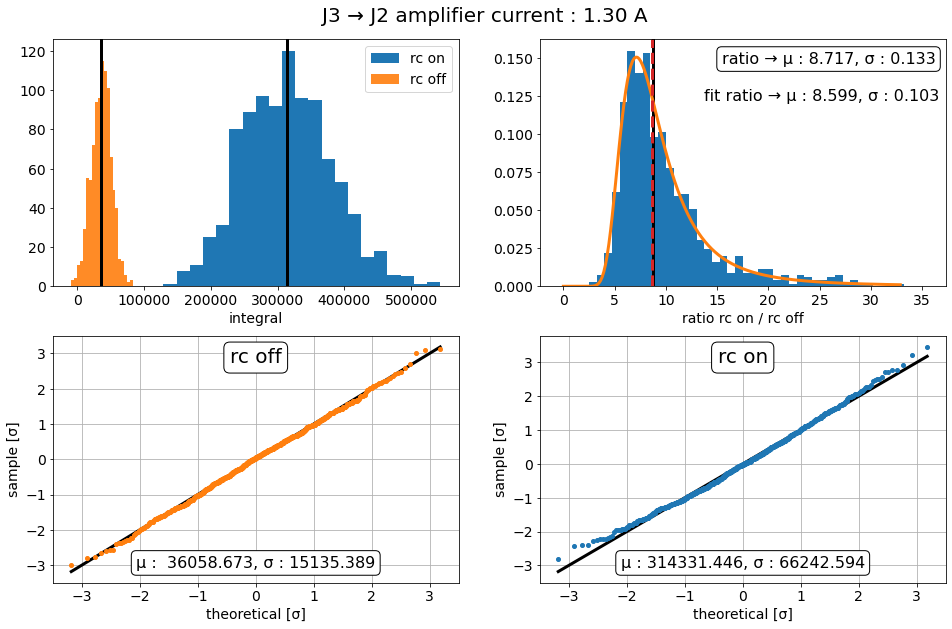

In [1149]:
intc_limit = 20e3
into_lowlim = 50e3
into_highlim = 1000e3
rlimit = 0.995

props = dict(boxstyle='round', facecolor='white', alpha=1)
ratios = {c: None for c in currents}
ratios_fit = {c: None for c in currents}

for idc in range(len(pmt_data_reshaped)):
    io = []
    ic = []
    
    suspect = False
    
    pmt_bunched = pmt_data_reshaped[idc].reshape(-1,nbunched,2500)
    shutter_bunched = shutter_data_reshaped[idc].reshape(-1,nbunched)
    
    for idx in range(len(pmt_bunched)):
        slice_open, slice_closed = get_shutter_slice(shutter_bunched[idx][0])
        trapio = np.trapz(pmt_bunched[idx][slice_open], axis = 1)
        trapic = np.trapz(pmt_bunched[idx][slice_closed], axis = 1)
        if (np.mean(trapic) > int_limit) and (np.mean(trapio) < into_highlim):
            trapio[trapio < into_lowlim] = np.nan
            io.extend(trapio)
            ic.extend(trapic)
        else:
            pass

    io = np.asarray(io)
    ic = np.asarray(ic)

    
    fig, axes = plt.subplots(2,2,figsize = (16,10))
    fig.suptitle(f'J3 → J2 amplifier current : {currents[idc]:.2f} A', fontsize = 20,
                 y = .925, va = 'top')
    
    ax = axes[0,1]
    bin_width = 0.75
    nr, br, _ = ax.hist(io/ic, bins = np.arange(-0.5,35.5+bin_width,bin_width), density = True)
    ax.set_xlabel('ratio rc on / rc off')
    
    io = np.asarray([val for val in io if not np.isnan(val)])
    ic = np.asarray([val for val in ic if not np.isnan(val)])
    
    ax = axes[0,0]
    
    no, bo, _ = ax.hist(io, bins = 21, label = 'rc on')
    nc, bc, _ = ax.hist(ic, bins = 21, label = 'rc off', alpha = 0.9)
    
    ax.axvline(np.nanmean(io), lw = 3, color = 'k')
    ax.axvline(np.nanmean(ic), lw = 3, color = 'k')
    
    ax.locator_params(nbins=8)
    ax.set_xlabel('integral')

    ax.legend(fontsize = 14)
    
    ffunc = lambda x, a, b: a*x+b
    
    (osm, osr), (fitparams) = probplot(ic, dist = 'norm', fit = True)   
    
    suspect |= fitparams[-1] < rlimit
    
    μc = fitparams[1]
    σc = fitparams[0]

    _x = np.linspace(osm.min(), osm.max(), 101)
    
    ax = axes[1,0]
    ax.plot(_x, (ffunc(_x, *fitparams[:2]) - μc)/σc, lw = 3, color = 'k')
    ax.plot(osm, (osr - μc)/σc, '.', ms = 8, color = 'C1')
    
    ax.set_xlabel('theoretical [σ]')
    ax.set_ylabel('sample [σ]')
    ax.text(0.5, 0.95, 'rc off', fontsize = 20, transform = ax.transAxes, ha = 'center', va = 'top', bbox = props)
    ax.text(0.5, 0.05, f'μ : {μc:>10.3f}, σ : {σc:.3f}',
            transform = ax.transAxes, ha = 'center', va = 'bottom', fontsize = 16, bbox = props)
    ax.grid(True)    

    (osm, osr), (fitparams) = probplot(io, dist = 'norm', fit = True) 
    
    suspect |= fitparams[-1] < rlimit
    
    μo = fitparams[1]
    σo = fitparams[0]
    
    _x = np.linspace(osm.min(), osm.max(), 101)
    
    ax = axes[1,1]
    ax.plot(_x, (ffunc(_x, *fitparams[:2]) - μo)/σo, lw = 3, color = 'k')
    ax.plot(osm, (osr - μo)/σo, '.', ms = 8, color = 'C0')
    
    ax.set_xlabel('theoretical [σ]')
    ax.set_ylabel('sample [σ]')
    ax.text(0.5, 0.95, 'rc on', fontsize = 20, transform = ax.transAxes, ha = 'center', va = 'top', bbox = props)
    ax.text(0.5, 0.05, f'μ : {μo:>10.3f}, σ : {σo:.3f}',
            transform = ax.transAxes, ha = 'center', va = 'bottom', fontsize = 16, bbox = props)
    ax.grid(True)
    
    for ax in axes.flatten():
        set_fontsize(ax, 14)

    μr = μo/μc
    σr = np.abs(μr) * np.sqrt((σo/μo/np.sqrt(len(io)))**2 + (σc/μc/np.sqrt(len(ic)))**2)
    ratios[currents[idc]] = (μr, σr, suspect)
    
    ax = axes[0,1]
    ax.axvline(μr, color = 'k', lw = 3)
    ax.text(0.975, 0.95, f'ratio → μ : {μr:.3f}, σ : {σr:.3f}',
                transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 16, bbox = props)  

#     ffunc = lambda _x, *args, a: a*ratio_pdf(_x, *args)
    ffunc = lambda _x, *args: ratio_pdf(_x, *args)
    try:
        _x = br[:-1]+np.diff(br)[0]/2
#         p0 = (μo, μc, σo, σc, nr.max()*8.5)
#         bounds = ((μo-σo, μc-σc, 0.5*σo, 0.5*σc, 0), (μo+σo, μc+σc, 1.5*σo, 1.5*σc, np.inf))

        p0 = (μo, μc, σo, σc)
        bounds = ((μo-σo, μc-σc, 0.5*σo, 0.5*σc), (μo+σo, μc+σc, 1.5*σo, 1.5*σc))
        
        mask = nr > 0
        nr = nr[mask]
        _x = _x[mask]
        sigma = np.sqrt(nr)
        sigma[sigma == 0] = 1
        popt, pcov = curve_fit(ffunc, _x, nr, sigma = sigma, p0 = p0, bounds = bounds,
                               maxfev = 10000, absolute_sigma = False)
        
        _x = np.linspace(0, _x.max(), 201)
        ax.plot(_x, ffunc(_x, *popt), color = 'C1', lw = 3)
    except Exception as e:
        ax.plot(_x, ffunc(_x, *p0), color = 'C1', lw = 3)
        print(e)
        
    μfo = popt[0]
    μfc = popt[1]
    σfo = popt[2]
    σfc = popt[3]
    μfr = μfo/μfc
    σfr = np.abs(μfr) * np.sqrt((σfo/μfo/np.sqrt(len(io)))**2 + (σfc/μfc/np.sqrt(len(ic)))**2)
    ratios_fit[currents[idc]] = (μfr, σfr, suspect)
    
    ax.axvline(μfr, color = 'C3', lw = 3, ls = '--')
    
    ax.text(0.985, 0.8, f'fit ratio → μ : {μfr:.3f}, σ : {σfr:.3f}',
            transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 16)

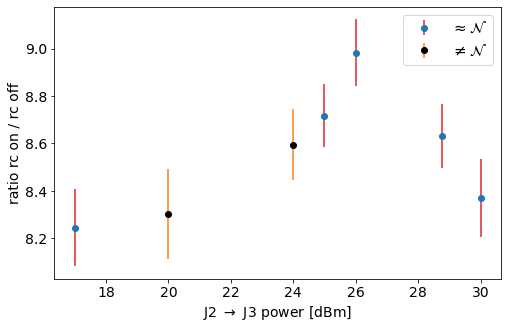

In [1150]:
c = list(ratios.keys())
r, e, s = zip(*list(ratios.values()))
c,r,e,s = np.asarray(c), np.asarray(r), np.asarray(e), np.asarray(s)
p = np.array([current_to_power[ci] for ci in c])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(p[~s], r[~s], yerr = e[~s], fmt = '.', ms = 12, ecolor = 'C3', label = r'$\approx\mathcal{N}$')
ax.errorbar(p[s], r[s], yerr = e[s], fmt = '.', ms = 12, ecolor = 'C1', color = 'k', label = r'$\neq\mathcal{N}$')

ax.legend(fontsize = 15)
ax.set_xlabel(r'J2 $\rightarrow$ J3 power [dBm]')
ax.set_ylabel('ratio rc on / rc off')
set_fontsize(ax, 14)

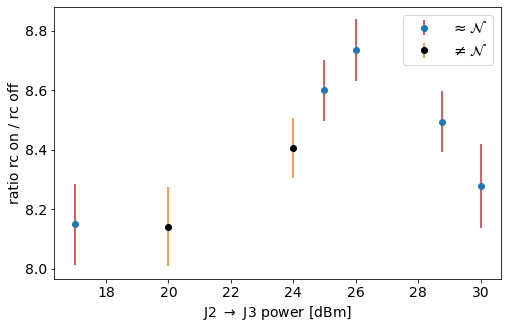

In [1151]:
c = list(ratios_fit.keys())
r, e, s = zip(*list(ratios_fit.values()))
c,r,e,s = np.asarray(c), np.asarray(r), np.asarray(e), np.asarray(s)
p = np.array([current_to_power[ci] for ci in c])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(p[~s], r[~s], yerr = e[~s], fmt = '.', ms = 12, ecolor = 'C3', label = r'$\approx\mathcal{N}$')
ax.errorbar(p[s], r[s], yerr = e[s], fmt = '.', ms = 12, ecolor = 'C1', color = 'k', label = r'$\neq\mathcal{N}$')

ax.legend(fontsize = 15)
ax.set_xlabel(r'J2 $\rightarrow$ J3 power [dBm]')
ax.set_ylabel('ratio rc on / rc off')
set_fontsize(ax, 14)

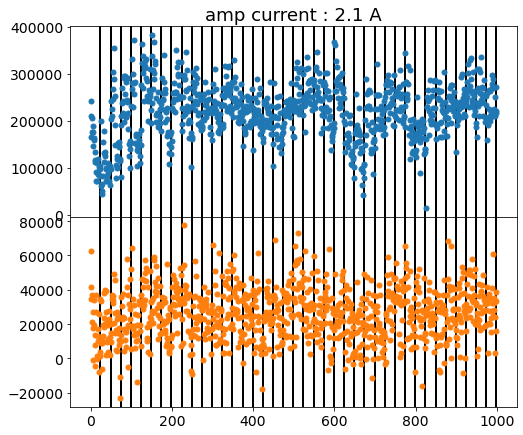

In [1114]:
for idc in range(len(pmt_data_reshaped[:1])):
    io = []
    ic = []
    
    suspect = False
    
    pmt_bunched = pmt_data_reshaped[idc].reshape(-1,nbunched,2500)
    shutter_bunched = shutter_data_reshaped[idc].reshape(-1,nbunched)
    
    fig, axes = plt.subplots(2,figsize = (8,7), sharex = True,
                             gridspec_kw = {'hspace': 0})
    
    counter = 0
    for idx in range(len(pmt_bunched)):
        slice_open, slice_closed = get_shutter_slice(shutter_bunched[idx][0])
        trapio = np.trapz(pmt_bunched[idx][slice_open], axis = 1)
        trapic = np.trapz(pmt_bunched[idx][slice_closed], axis = 1)
        _ = np.arange(len(trapio))+counter*len(trapio)
        counter += 1
        axes[0].plot(_, trapio, '.', ms = 10, color = 'C0')
        axes[1].plot(_, trapic, '.', ms = 10, color = 'C1')
        axes[0].axvline(_.max(), color = 'k', lw = 2, zorder = 0)
        axes[1].axvline(_.max(), color = 'k', lw = 2, zorder = 0)
        
    axes[0].set_title(f'amp current : {currents[idc]} A')
    [set_fontsize(ax, 14) for ax in axes]

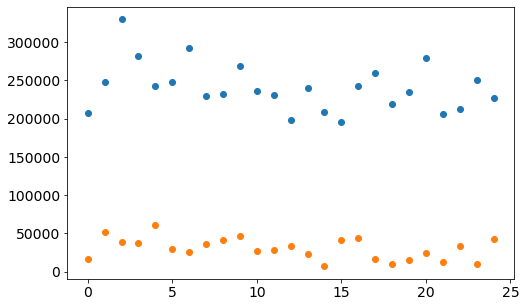

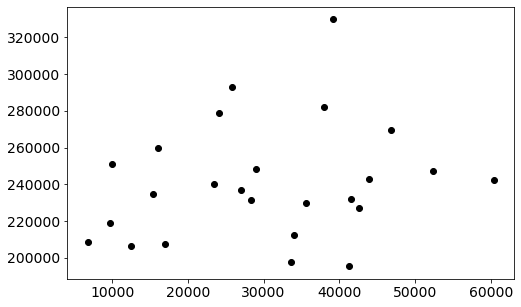

In [1142]:
idc = 0
idb = 14

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.trapz(pmt_data_reshaped[idc].reshape(-1,50,2500)[idb], axis = 1)[::2], '.', ms = 12)
ax.plot(np.trapz(pmt_data_reshaped[idc].reshape(-1,50,2500)[idb], axis = 1)[1::2], '.', ms = 12)
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
ax.scatter(np.trapz(pmt_data_reshaped[idc].reshape(-1,50,2500)[idb], axis = 1)[1::2], 
           np.trapz(pmt_data_reshaped[idc].reshape(-1,50,2500)[idb], axis = 1)[::2],
           color = 'k')
set_fontsize(ax, 14)